In [1]:
# in this notebook we will explore all about different hyperparameters to get optimal results for a neural network.
# we will use simple ANN model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
import keras

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import BatchNormalization, Activation, LayerNormalization, GroupNormalization
from keras.optimizers import SGD
from keras.constraints import max_norm
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from keras.initializers import constant
from keras import regularizers

from scikeras.wrappers import KerasClassifier

# [pip install scikit-optimize]
from skopt import BayesSearchCV
# BayesSearchCV is another hyperparameter tuning algorithm that uses bayesian statistics of the model and the relationship between hyperparameters and performance and selects the next hyperparameter based on the performance , thus tuning hyperparameters optimally.

# BayesSearchCV and RandomizedSearchCV is faster than GridSearchCV

import tensorflow as tf

import pickle

import math

In [2]:
tf.get_logger().setLevel('ERROR') #hides tendorflow info and warnings

###### we are going to use diabetes datasets from the standard UCI machine learning repository.
###### the dataset contains the information : 
        Input Variables (X):

            Number of times pregnant
            Plasma glucose concentration at 2 hours in an oral glucose tolerance test
            Diastolic blood pressure (mm Hg)
            Triceps skin fold thickness (mm)
            2-hour serum insulin (mu U/ml)
            Body mass index (weight in kg/(height in m)^2)
            Diabetes pedigree function
            Age (years)

        Output Variables (y):

            Class variable (0 or 1)

In [3]:
# NOTE : one of the crucial steps to get good predictions in your model is to get the data analysis right. scaling, normalization, handling missing values, resampling, etc are few things to be considered. but since this is out of scope for this notebook, we wont discuss it here.    

In [3]:
# loading the dataset
data = np.loadtxt("./datasets/diabetes.csv", delimiter=',')
data.shape

(768, 9)

In [4]:
x = data[:, :-1]
y = data[:, -1]
x.shape, y.shape

((768, 8), (768,))

In [5]:
# we will only perform basic data analysis as it's not the scope of this notebook
np.isnan(x).sum()

0

In [5]:
# splitting the data
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=1)

In [6]:
# standard scaler
scaler =  StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [9]:
xtrain.shape[1]

8

In [7]:
# NOTE : to save time, we will take small train data
xtrain_subset, _, ytrain_subset, _ = train_test_split(xtrain, ytrain, train_size=0.1, shuffle = True, stratify=ytrain, random_state=1)
# you can replace it with xtrain and ytrain to train on the full dataset

In [7]:
tf.random.set_seed(1) #setting seed

## hyperparameter tuning

In [10]:
# tuning epochs and batch size

def create_model() : 
    model = Sequential()
    model.add(Dense(8, input_shape = (8,), activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

model = KerasClassifier(model=create_model, verbose=0)
params = {
    'epochs' : [50, 60, 70],
    'batch_size' : [50, 80, 100]
}
gs = GridSearchCV(model, param_grid = params, scoring = 'accuracy')
result = gs.fit(xtrain_subset, ytrain_subset)


In [14]:
result.best_params_, result.best_score_

({'batch_size': 100, 'epochs': 60}, 0.7051282051282052)

In [15]:
# tuning optimizer

def create_model(optimizer = 'adam') : 
    model = Sequential()
    model.add(Dense(8, input_shape = (8,), activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    return model

model = KerasClassifier(create_model, loss='binary_crossentropy', metrics = ['accuracy'], batch_size=100, epochs = 60, verbose = 0)
params = {
    'model__optimizer' : ['adam', 'SGD']
}
gs = GridSearchCV(model, params, scoring='accuracy')
result = gs.fit(xtrain_subset, ytrain_subset)


In [16]:
result.best_params_, result.best_score_

({'model__optimizer': 'SGD'}, 0.7217948717948718)

In [17]:
# tuning epoch, batch_size and optimizer

def create_model(optimizer = 'adam') : 
    model = Sequential()
    model.add(Dense(8, input_shape = (8,), activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

model = KerasClassifier(create_model, verbose = 0)
params = {
    'epochs' : [60, 65],
    'batch_size' : [100],
    'model__optimizer' : [ 'SGD']
}
gs = GridSearchCV(model, params, scoring='accuracy')
result = gs.fit(xtrain_subset, ytrain_subset)

In [18]:
result.best_params_, result.best_score_

({'batch_size': 100, 'epochs': 60, 'model__optimizer': 'SGD'},
 0.7038461538461538)

In [19]:
# tuning the hyperparameters of optimizer

def create_model() : 
    model = Sequential()
    model.add(Dense(8, input_shape = (8,), activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    return model

model = KerasClassifier(create_model, optimizer = 'SGD', loss = 'binary_crossentropy', metrics = ['accuracy'], epochs = 60, batch_size = 100, verbose = 0)
params = {
    'optimizer__learning_rate' : [0.1, 0.01],
    'optimizer__momentum' : [0.8]
}
gs = GridSearchCV(model, params, scoring = 'accuracy')
result = gs.fit(xtrain_subset, ytrain_subset)

In [21]:
result.best_params_, result.best_score_

({'optimizer__learning_rate': 0.1, 'optimizer__momentum': 0.8},
 0.6858974358974359)

In [9]:
# tuning hyperparameters of optimizer, epochs, batch_size all at once
def create_model(optimizer):
    model = Sequential()
    model.add(Dense(8, input_shape = (8,), activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

model = KerasClassifier(create_model, verbose = 0)
params = {
    'model__optimizer' : ['adam', 'SGD'],
    'optimizer__learning_rate' : [0.1, 0.01],
    'optimizer__momentum' : [0.8],
    'epochs' : [70],
    'batch_size' : [112] 
}
gs = GridSearchCV(model, params, scoring = 'accuracy')
result = gs.fit(xtrain_subset, ytrain_subset)

In [11]:
result.best_params_, result.best_score_

({'batch_size': 112,
  'epochs': 70,
  'model__optimizer': 'adam',
  'optimizer__learning_rate': 0.1,
  'optimizer__momentum': 0.8},
 0.7051282051282051)

In [12]:
# tuning netwrok weights
def create_model(init_mode = 'RandomUniform'):
    model = Sequential()
    model.add(Dense(8, input_shape = (8,), activation = 'relu', kernel_initializer=init_mode))
    model.add(Dense(16, activation = 'relu', kernel_initializer=init_mode))
    model.add(Dense(1, activation = 'sigmoid' ,kernel_initializer='glorot_uniform'))
    model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

model = KerasClassifier(create_model, epochs = 100, batch_size = 100, verbose = 0)
params = {
    'model__init_mode' : ['he_uniform','ones']
}

gs = GridSearchCV(model, params, scoring = 'accuracy')
result = gs.fit(xtrain_subset, ytrain_subset)

In [13]:
result.best_params_, result.best_score_

({'model__init_mode': 'he_uniform'}, 0.6551282051282052)

In [21]:
# tuning activation functions
# NOTE : while tuning, the activation function in the output layer should be based on the dataset so we should not tune it.
# ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
def create_model(activation = 'relu'):
    model = Sequential()
    model.add(Dense(8, input_shape = (8,), activation = activation, ))
    model.add(Dense(16, activation = activation))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

model = KerasClassifier(create_model, epochs = 100, batch_size = 100, verbose = 0)
params = {
    'model__activation' : ['relu','softmax', 'swish']
}

gs = GridSearchCV(model, params, scoring = 'accuracy')
result = gs.fit(xtrain_subset, ytrain_subset)

In [22]:
result.best_params_, result.best_score_

({'model__activation': 'softmax'}, 0.6564102564102563)

In [34]:
# tuning dropout and weight constraint

def create_model(dropout_rate=0.2, weight_constraint = 3):
    model = Sequential()
    model.add(Dropout(dropout_rate, input_shape = (8,)))
    model.add(Dense(32, activation = 'relu', kernel_constraint=max_norm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation = 'relu', kernel_constraint=max_norm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation = 'relu', kernel_constraint=max_norm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

model = KerasClassifier(create_model, epochs = 100, batch_size = 100, verbose = 0)
params = {
    'model__dropout_rate' : [0.2, 0.4, 0.6],
    'model__weight_constraint' : [2 ,4, 5]
}

gs = GridSearchCV(model, params, scoring = 'accuracy')
result = gs.fit(xtrain_subset, ytrain_subset)

In [35]:
result.best_params_, result.best_score_

({'model__dropout_rate': 0.6, 'model__weight_constraint': 4},
 0.6897435897435897)

In [36]:
# tuning number of neurons in each layer

def create_model(neurons):
    model = Sequential()
    model.add(Dense(8, input_shape = (8,), activation = 'relu'))
    model.add(Dense(neurons, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

model = KerasClassifier(create_model,epochs = 70, batch_size = 100, verbose = 0)
params = {
    'model__neurons' : [15, 25, 35, 50]
}
gs = GridSearchCV(model, params, scoring = 'accuracy')
result = gs.fit(xtrain_subset, ytrain_subset)

In [37]:
result.best_params_, result.best_score_

({'model__neurons': 25}, 0.6705128205128206)

## weight initialization : 

initial weights are the starting point of the model's learning journey. if the initial weights are better, then the model willl be able to converge better   

NOTE : ITS BAD TO INITIALIZE WEIGHTS AS 0 AS THEIR GRADIENT IS ALSO 0

weight initialization techniques : 

    RandomNormal
    RandomUniform
    TruncatedNormal
    Orthogonal
    Identity
    zeros
    ones
    glorot_normal
    glorot_uniform
    he_normal
    he_uniform
    lecun_normal
    lecun_uniform

    for sigmoid/tanh activation functions : 
        uniform glorot /uniform xavier initialization
        normalized glorot / normalised xavier initialization

    for relu activation function:
        uniform he initialisation
        normalized he initialisation

In [9]:
model = Sequential()
model.add(Dense(8, input_shape = (8,), activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(16, activation = 'relu', kernel_initializer = 'he_uniform'))
model.add(Dense(1, activation='sigmoid', kernel_initializer = constant(0.1))) # you can add constant weight using keras.initializer.constant()
model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(xtrain_subset, ytrain_subset)
model.evaluate(xtest, ytest) 

# NOTE : you can use 'bias_initializer' to initialize bias values for each layer

5/5 [==============================] - 0s 7ms/step - loss: 0.7502 - accuracy: 0.5909


[0.7501676678657532, 0.5909090638160706]

## bias initialization 
    bias can be initialized as 0.
    but for RELUs, its better to keep bias as a very small number like(0.1/0.001) due to the problem of leaky RELU

In [10]:
model = Sequential()
model.add(Dense(8, input_shape = (8,), activation='relu', bias_initializer='he_uniform')) # you can use the same values used in weight initialization like he_uniform, he_normal, etc
model.add(Dense(16, activation = 'relu', bias_initializer = constant(0.1))) #use keras.initializer.constant() to initialize constant values to the bias
model.add(Dense(1, activation='sigmoid', bias_initializer = constant(0.1)))
model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(xtrain, ytrain)
model.evaluate(xtest, ytest) 

5/5 [==============================] - 0s 9ms/step - loss: 0.7901 - accuracy: 0.4416


[0.790073812007904, 0.44155845046043396]

## dropout : 
    the randomly selected neurons are ignored during the training. the neurons are dropped at random, which means that their contribution during the foreward pass is temporarily removed and the weights are no longer updated during backward pass. 

    dropout is only used in the training of the model but not while evaluating the skill of the model

    this helps in overfitting of the model.

    tips to use dropout(): 
        -> use larger network while using dropout, as it will let the model to learn without any constrain
        -> start from 20% dropout.(20-50% is generally recommended)
        -> use dropout in input as well as hidden layers
        -> increase learning rate by a factor of 10 - 100 and high momentum like 0.9 or 0.99
        -> add kernel constrains. use max norm constrain with a size of 4 to 5


In [26]:
# model without dropout

model = Sequential()
model.add(Dense(8, input_shape = (8,), activation = 'relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(xtrain, ytrain, epochs = 70, batch_size = 100, validation_data =  (xtest, ytest), verbose = 0)
model.evaluate(xtest, ytest)

5/5 [==============================] - 0s 6ms/step - loss: 0.5957 - accuracy: 0.6688


[0.5956513285636902, 0.6688311696052551]

In [29]:
# model  with dropout

model = Sequential()
model.add(Dropout(0.2, input_shape = (8,)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(xtrain, ytrain, epochs = 70, batch_size = 100, validation_data =  (xtest, ytest), verbose = 0)
model.evaluate(xtest, ytest)

5/5 [==============================] - 0s 10ms/step - loss: 0.5327 - accuracy: 0.7597


[0.5327013731002808, 0.7597402334213257]

## learning rate scheduler
    adapting learning rate to get more accurate results.

    most commonly used technique is reducing the learning rate gradually till we reach the best results.
    techniques : 
        -> (time-based learning rate schedule) decreasing the learning rate gradually based on epoch. for example, learning rate decreases by 0.0001 at every epoch.
        -> (drop-based learning rate schedule) decreasing the learning rate using punctuated large drops at specific epochs. for example, learning rate drops by 20% or by 0.3 after every 10 epochs
    

    NOTE : keep the initial learning rate and momentum high so that when we decrease the learning rate during training, we will still be able to update the learning rate at resonable rate.

In [14]:
# time-based learning rate scheduling : 

model = Sequential()
model.add(Dense(8, input_shape = (8,), activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

learning_rate = 0.1
epochs = 70
decay = learning_rate / epochs # decay parameter decreases the learning rate after every epoch

sgd = SGD(learning_rate=0.1, momentum=0.9, nesterov=False, weight_decay=decay)
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(xtrain, ytrain, epochs = epochs, batch_size = 100, validation_data = (xtest, ytest), verbose = 0)
model.evaluate(xtest, ytest)

5/5 [==============================] - 0s 8ms/step - loss: 0.5487 - accuracy: 0.7922


[0.5486501455307007, 0.7922077775001526]

In [22]:
# drop based learning rate schedule : reducing the learning rate by 'x' after every 'n' epoch. we can implement this using LearningRateScheduler() from keras.callbacks

# NOTE : try to experiment with different schedulers like exponential scheduler, cosine scheduler, polynomial decay, linear decay, etc

# step decay
model = Sequential()
model.add(Dense(8, input_shape = (8,), activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = 'accuracy')

def step_decay(epoch) : 
    initial_lrate = 0.1
    epochs_drop = 10
    drop = 0.5
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)
model.fit(xtrain, ytrain, epochs = 70, batch_size =100,callbacks=[lrate],  validation_data = (xtest, ytest), verbose = 0)
model.evaluate(xtest, ytest)

5/5 [==============================] - 0s 20ms/step - loss: 0.4851 - accuracy: 0.7987


[0.48512595891952515, 0.798701286315918]

## batch normalization
    performing normalization(re-centering and re-scaling) on the layer input. its job is to take the output of the previous layer, normalize them before passing it to the next layer

    it also helps us to use higher learning rates. without it, we will need to keep the learning rate small to not miss the global minima 

    it helps in reducing the dependence on the initial weights as they are assigned randomly at the start of the training. since weights are assigned at random, outlier weight can cause larger adjustment, which causes the model more time to converge.

    this helps in faster and more stable training of the neural network(espically on large networks).

    NOTE : batch normalization may not work well with some layers, so do your research while using it with different architectures. batch normalization does not work well with RNN as 

    batch normalization may not work well if the batch size is small. batch normalization needs to calculate mean and variance across the batches so it might not work well if the batch size is small. 
        why we cant simple increase the batch size?
            higher batch size causes higher gradients, which will let the model to take big jumps and may miss the global minima.
            
            also, simply increasing the batch size reduces the size of each batch so we need to find the sweet spot of batch size so that we can use batch normalization effectively and also it doesnt affect the model with higher gradients.

In [ ]:

    # when BatchNormalization layer is placed right after the input layer, we should mention the 'input_shape'  parameter.
        # model = Sequential()
        # model.add(BatchNormalization(input_shape=(2,)))

    # when batchnormalization layer is placed after hidden layer, there is no ned to mention the 'input_shape' parameter.
        # model = Sequential()
        # ...
        # model.add(BatchNormalization())




# placing batch normalization layer : 
    # placing batch normalization layer before activation function : 
        # model.add(Dense())
        # model.add(BatchNormalization())
        # model.add(Activation("relu"))
    # placing batch normalization layer after activation function : 
        #model.add(Dense(23, activation = 'relu'))
        #model.add(BatchNormalization())

# the original research paper suggests that the batch normalization layer to be placed before activation layer to get better results but some examples suggest that placing batch normalization layer after the activation layer gives better results. so ,try both variations.

In [8]:
# without batch normalization
model = Sequential()
model.add(Dense(8, input_shape = (8,), activation='relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer= 'SGD', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(xtrain, ytrain, epochs = 70, batch_size = 100, verbose = 0)
model.evaluate(xtest, ytest)





5/5 [==============================] - 1s 8ms/step - loss: 0.5744 - accuracy: 0.7013


[0.5743611454963684, 0.701298713684082]

In [9]:
# placing batch normalization layer after the activation function
model = Sequential()
model.add(Dense(8, input_shape = (8,), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer= 'SGD', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(xtrain, ytrain, epochs = 70, batch_size = 100, verbose = 0)
model.evaluate(xtest, ytest)

5/5 [==============================] - 1s 12ms/step - loss: 0.4619 - accuracy: 0.7792


[0.4619080722332001, 0.7792207598686218]

In [10]:
# placing batch normalization before activation function
model = Sequential()
model.add(Dense(8, input_shape = (8,)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer= 'SGD', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(xtrain, ytrain, epochs = 70, batch_size = 100, verbose = 0)
model.evaluate(xtest, ytest)

5/5 [==============================] - 1s 7ms/step - loss: 0.4811 - accuracy: 0.7662


[0.48109838366508484, 0.7662337422370911]

In [23]:
# placing the batch normalization right after the input layer 
model = Sequential()
model.add(BatchNormalization(input_shape = (8,)))
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer= 'SGD', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(xtrain, ytrain, epochs = 70, batch_size = 100, verbose = 0)
# model.evaluate(xtest, ytest)
eval = KerasClassifier(model)
kfolds = StratifiedKFold(n_splits = 3, shuffle = True, random_state=1)
cross_val_score(eval, xtest, ytest, cv = kfolds, scoring = 'accuracy').mean()

2/2 [==============================] - 1s 16ms/step


0.7723730517848164

In [24]:
# setting axis = 1 as a parameter in batchnormalization()

model = Sequential()
model.add(BatchNormalization(input_shape = (8,)))
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization(axis = 1))
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization(axis = 1))
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization(axis = 1))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer= 'SGD', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(xtrain, ytrain, epochs = 70, batch_size = 100, verbose = 0)
# model.evaluate(xtest, ytest)
eval = KerasClassifier(model)
kfolds = StratifiedKFold(n_splits = 3, shuffle = True, random_state=1)
cross_val_score(eval, xtest, ytest, cv = kfolds, scoring = 'accuracy').mean()

2/2 [==============================] - 1s 35ms/step


0.785570638511815

you can notice a significant boost in the accuracy after adding the batch normalization layer

**IMPORTANT : we can able to notice a accuracy boost when we pass 'axis = 1' as a parameter in BatchNormalization(). the same trend is also noticed in the other normalization layers that are discussed below.**

In [ ]:
# other Normalization layers : 
    # -> layer normalization - this technique performs than batch normalization when the batch_size and number of batchs are small.
    # -> group normalization - normalization technique where the data is divided into groups. here, the batch_size and the number of batches doesn't matter. 
            # when number of groups = 1, then GroupNormalization behaves identical to LayerNormalization.
            # when number of groups = N(where N = number of channels), then GroupNormalization behaves identical to InstanceNormalization.
            # so, when using GroupNormalization, we use number of groups = X(where 1<X<N). [X should be a divisible of N]
    # -> instance normalization - mostly used when working with images. but experiment with different normalizations during implementation. in keras, there is no specific function to implement InstanceNormalization. so we simply use GroupNormalization(groups = N)[where N = number of input channels]

![GN_BN_LN_IN normalizations.png](<attachment:GN_BN_LN_IN normalizations.png>)
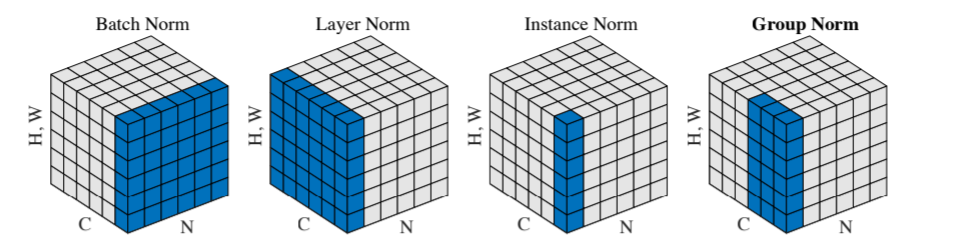

In [45]:
# layer normalization

model = Sequential()
model.add(Dense(8, input_shape = (8,), activation='relu'))
model.add(LayerNormalization())
model.add(Dense(64, activation = 'relu'))
model.add(LayerNormalization())
model.add(Dense(128, activation = 'relu'))
model.add(LayerNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer= 'SGD', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(xtrain, ytrain, epochs = 70, batch_size = 100, verbose = 0)
model.evaluate(xtest, ytest)

5/5 [==============================] - 2s 20ms/step - loss: 0.4965 - accuracy: 0.8052


[0.49648919701576233, 0.8051947951316833]

In [44]:
# LayerNormalization(axis = 1)
model = Sequential()
model.add(Dense(8, input_shape = (8,), activation='relu'))
model.add(LayerNormalization(axis = 1))
model.add(Dense(64, activation = 'relu'))
model.add(LayerNormalization(axis = 1))
model.add(Dense(128, activation = 'relu'))
model.add(LayerNormalization(axis = 1))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer= 'SGD', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(xtrain, ytrain, epochs = 70, batch_size = 100, verbose = 0)
model.evaluate(xtest, ytest)

5/5 [==============================] - 1s 18ms/step - loss: 0.4930 - accuracy: 0.7857


[0.4929538667201996, 0.7857142686843872]

In [50]:
# actual implementation of GroupNormalization
model = Sequential()
model.add(Dense(8, input_shape = (8,), activation='relu'))
model.add(GroupNormalization(groups = 4))
model.add(Dense(64, activation = 'relu'))
model.add(GroupNormalization(groups = 4))
model.add(Dense(128, activation = 'relu'))
model.add(GroupNormalization(groups = 4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer= 'SGD', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(xtrain, ytrain, epochs = 70, batch_size = 100, verbose = 0)
model.evaluate(xtest, ytest)

5/5 [==============================] - 2s 5ms/step - loss: 0.6025 - accuracy: 0.7143


[0.6024887561798096, 0.7142857313156128]

In [42]:
# group normalization [when groups = 1, GroupNormalization() becomes identical to the layer normalization]

model = Sequential()
model.add(Dense(8, input_shape = (8,), activation='relu'))
model.add(GroupNormalization(groups = 1))
model.add(Dense(64, activation = 'relu'))
model.add(GroupNormalization(groups = 1))
model.add(Dense(128, activation = 'relu'))
model.add(GroupNormalization(groups = 1))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer= 'SGD', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(xtrain, ytrain, epochs = 70, batch_size = 100, verbose = 0)
model.evaluate(xtest, ytest)

5/5 [==============================] - 1s 10ms/step - loss: 0.5285 - accuracy: 0.7727


[0.528499186038971, 0.7727272510528564]

In [47]:
# group normalization when groups = number of input chanels(in this case, 8) or -1, this operation becomes identical to the instance normalization

model = Sequential()
model.add(Dense(8, input_shape = (8,), activation='relu'))
model.add(GroupNormalization(groups = -1))
model.add(Dense(64, activation = 'relu'))
model.add(GroupNormalization(groups = -1))
model.add(Dense(128, activation = 'relu'))
model.add(GroupNormalization(groups = -1))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer= 'SGD', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(xtrain, ytrain, epochs = 70, batch_size = 100, verbose = 0)
model.evaluate(xtest, ytest)

5/5 [==============================] - 1s 8ms/step - loss: 0.6518 - accuracy: 0.6429


[0.6518314480781555, 0.6428571343421936]

## early stopping
    we never really know when to stop the model training(i.e., determining right number of epochs). if epochs are too high, then the model overfits and if the epochs are too small, then the model underfits. in both the cases, the model will not be able to generalize properly. so, we use 'early stopping' technique to stop the model traning when there is no change/very minimal change in the accuracy/loss of the model during traning. 

In [10]:
# we will use 'callbacks' parameter from model.fit() to interact with the model during training.
# when you have multiple callbacks, we pass a list of callbacks
        # cb = Callback()
        # cb2 = Callback()
        # callback_list = [cb, cb2]
        # model.fit(...., callbacks = [cb, cb2])


# implementing callback
    # NOTE : to implement callback, we need to pass validation data separately during training. we can do this in 2 ways.
        # method 1 : we split the dataset separately into train, validate, test using sklearn.model_selection.train_test_split() and pass it in model.fit() like this : model.fit(validation_data = (val_x, val_y))
        # method 2 : we split the dataset into train and test set using sklearn.model_selection.train_test_split() and we specify percentage of validation set that will be used for validation from training set like this : model.fit(validation_split = 0.3)

    # NOTE : keras.callbacks.EarlyStopping() : 
        # parameters : 
            # measure : specifies what measure Earlystopping() will track to implement early stopping. model.fit() returns 4 measures : accuracy, loss, val_accuracy and val_loss(val_accuracy and val_loss are accuracy and loss of the validation data). mostly we use 'val_loss' to track the performance of the model.
            # mode : this parameter either 'min' or 'max' as value. it depends on the measure we have chosen. for example, if we use measure = 'val_accuracy', then we set mode = 'max' as we want to maximize the accuracy. if measure = 'val_loss', then we set mode = 'min' as we want to minimize the loss. by default, mode = 'auto'. it automatically knows that we want to minimize the loss and maximize the accuracy.
            # patience : if the patience is not specified, then EarlyStopping() will stop the model training right after the first sign of no improvement(i.e., consider val_loss at epoch 10 is 1.45, if val_loss at epoch 11 is also 1.45, then the model training will be stopped). but this is not the best time to stop the training because sometimes the model might be stuck in a plateau and after few epochs it may result in a way better performance. so when patience = n, EarlyStopping() will only stop the training when the value remains unchanged for 'n' epochs
            # min_delta : minimum change in the measure to be considered as imporvement. for example, EarlyStopping(measure = 'val_accuracy', min_delta = 1), then training will the terminated if the model does not improve by atleast 1 unit at every epoch.
            # baseline : sometime, if you want to achieve only 0.12 loss and you dont want to train the model after loss = 0.12, then we can set baseline as 0.12. once it is achieved, the training is terminated.

    # NOTE : ModelCheckpoint(filepath, monitor, mode, save_best_only : bool, verbose) : [keras.callbacks.ModelCheckpoint]
                # sometimes, the final model we get after EarlyStopping may not be the best model we require, so we can save the best model using ModelCheckpoint()

In [9]:
# without early stopping
model = Sequential()
model.add(Dense(500, input_shape = (8, ), activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = 'accuracy')
his = model.fit(xtrain, ytrain, epochs = 4000, batch_size = 70, verbose = 0)

# evaluating on train set
print(model.evaluate(xtrain, ytrain))
#evaluating on test set
print(model.evaluate(xtest, ytest))

20/20 [==============================] - 1s 7ms/step - loss: 0.2828 - accuracy: 0.8925
[0.2827650308609009, 0.8925081491470337]
5/5 [==============================] - 0s 11ms/step - loss: 0.5007 - accuracy: 0.8117
[0.5006946325302124, 0.8116883039474487]


In [14]:
# with early stopping
model = Sequential()
model.add(Dense(500, input_shape = (8, ), activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = 'accuracy')
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 30, verbose = 1)
mc = ModelCheckpoint('./saved_models/early_stopping/best_model.keras', monitor = 'val_accuracy', mode = 'max', save_best_only=True, verbose = 1)
es_his = model.fit(xtrain, ytrain, epochs = 4000, batch_size = 70, callbacks = [es, mc], validation_data = (xtest, ytest), verbose = 0)

# evaluating on train set
print(model.evaluate(xtrain, ytrain))
#evaluating on test set
print(model.evaluate(xtest, ytest))


Epoch 1: val_accuracy improved from -inf to 0.68831, saving model to ./saved_models/early_stopping\best_model.keras

Epoch 2: val_accuracy improved from 0.68831 to 0.70779, saving model to ./saved_models/early_stopping\best_model.keras

Epoch 3: val_accuracy improved from 0.70779 to 0.71429, saving model to ./saved_models/early_stopping\best_model.keras

Epoch 4: val_accuracy did not improve from 0.71429

Epoch 5: val_accuracy improved from 0.71429 to 0.72078, saving model to ./saved_models/early_stopping\best_model.keras

Epoch 6: val_accuracy improved from 0.72078 to 0.73377, saving model to ./saved_models/early_stopping\best_model.keras

Epoch 7: val_accuracy improved from 0.73377 to 0.74675, saving model to ./saved_models/early_stopping\best_model.keras

Epoch 8: val_accuracy improved from 0.74675 to 0.75974, saving model to ./saved_models/early_stopping\best_model.keras

Epoch 9: val_accuracy improved from 0.75974 to 0.77273, saving model to ./saved_models/early_stopping\best_mod

the training was stopped at after 436th epoch

In [15]:
model = load_model('./saved_models/early_stopping/best_model.keras')
# evaluating on train set
print(model.evaluate(xtrain, ytrain))
#evaluating on test set
print(model.evaluate(xtest, ytest))

20/20 [==============================] - 2s 21ms/step - loss: 0.4287 - accuracy: 0.7883
[0.4286772310733795, 0.7882736325263977]
5/5 [==============================] - 0s 15ms/step - loss: 0.4606 - accuracy: 0.8052
[0.4605841636657715, 0.8051947951316833]


## model checkpoint
    keras.callbacks.ModelCheckpoint()
    saving the training process so that even if the model training stopped suddenly, the progress won't be lost.

In [14]:
# saving only the best model

model = Sequential()
model.add(Dense(8, input_shape = (8,), activation='relu'))
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = 'accuracy')

ms = ModelCheckpoint(f'./saved_models/model_checkpoint/best_model_only/best_model.keras', monitor='accuracy', mode = 'max', verbose = 1, save_best_only=True) # only save the model when there is a improvement in accuracy
model.fit(xtrain, ytrain, validation_data = (xtest, ytest), epochs = 1000, batch_size = 50, callbacks = [ms], verbose = 0)


Epoch 1: accuracy improved from -inf to 0.44951, saving model to ./saved_models/model_checkpoint/best_model_only\best_model.keras

Epoch 2: accuracy improved from 0.44951 to 0.68078, saving model to ./saved_models/model_checkpoint/best_model_only\best_model.keras

Epoch 3: accuracy did not improve from 0.68078

Epoch 4: accuracy did not improve from 0.68078

Epoch 5: accuracy did not improve from 0.68078

Epoch 6: accuracy did not improve from 0.68078

Epoch 7: accuracy did not improve from 0.68078

Epoch 8: accuracy did not improve from 0.68078

Epoch 9: accuracy improved from 0.68078 to 0.68567, saving model to ./saved_models/model_checkpoint/best_model_only\best_model.keras

Epoch 10: accuracy did not improve from 0.68567

Epoch 11: accuracy improved from 0.68567 to 0.68730, saving model to ./saved_models/model_checkpoint/best_model_only\best_model.keras

Epoch 12: accuracy did not improve from 0.68730

Epoch 13: accuracy improved from 0.68730 to 0.69870, saving model to ./saved_mo

In [21]:
# saving all the models

model = Sequential()
model.add(Dense(8, input_shape = (8,), activation='relu'))
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = 'accuracy')
ms = ModelCheckpoint("./saved_models/model_checkpoint/all_models/model_{epoch:03d}_{val_accuracy:.2f}.keras", monitor='val_accuracy', mode = 'max', verbose = 1)
model.fit(xtrain, ytrain, validation_data = (xtest, ytest), epochs = 5, batch_size = 50, callbacks = [ms], verbose = 0)


Epoch 1: saving model to ./saved_models/model_checkpoint/all_models\model_001_0.64.keras

Epoch 2: saving model to ./saved_models/model_checkpoint/all_models\model_002_0.65.keras

Epoch 3: saving model to ./saved_models/model_checkpoint/all_models\model_003_0.66.keras

Epoch 4: saving model to ./saved_models/model_checkpoint/all_models\model_004_0.66.keras

Epoch 5: saving model to ./saved_models/model_checkpoint/all_models\model_005_0.66.keras


In [22]:
# saving all models where there is improvement

model = Sequential()
model.add(Dense(8, input_shape = (8,), activation='relu'))
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = 'accuracy')

ms = ModelCheckpoint('./saved_models/model_checkpoint/all_best/model_{epoch:03d}_{accuracy:.2f}.keras', monitor='accuracy', mode = 'max', verbose = 1, save_best_only=True) # only save the model when there is a improvement in accuracy
model.fit(xtrain, ytrain, validation_data = (xtest, ytest), epochs = 10, batch_size = 50, callbacks = [ms], verbose = 0)


Epoch 1: accuracy improved from -inf to 0.52769, saving model to ./saved_models/model_checkpoint/all_best\model_001_0.53.keras

Epoch 2: accuracy improved from 0.52769 to 0.67101, saving model to ./saved_models/model_checkpoint/all_best\model_002_0.67.keras

Epoch 3: accuracy did not improve from 0.67101

Epoch 4: accuracy did not improve from 0.67101

Epoch 5: accuracy did not improve from 0.67101

Epoch 6: accuracy did not improve from 0.67101

Epoch 7: accuracy did not improve from 0.67101

Epoch 8: accuracy did not improve from 0.67101

Epoch 9: accuracy did not improve from 0.67101

Epoch 10: accuracy did not improve from 0.67101


In [23]:
# loading saved model

# NOTE : here, ModelCheckpoint() only saved the model weights(it is assumed that network architecture is known). if you want to save the model including architecture, use save_model()[disscussed further in the notebook]

model = Sequential()
model.add(Dense(8, input_shape = (8,), activation='relu'))
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = 'accuracy')

# we will load the weights from ./saved_models/model_checkpoint/best_model_only/best_model.keras
model.load_weights('./saved_models/model_checkpoint/best_model_only/best_model.keras')
model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = 'accuracy')

# no need to fit the data again, we can directly use the model for predictions
model.evaluate(xtest, ytest)

5/5 [==============================] - 2s 24ms/step - loss: 0.4604 - accuracy: 0.8117


[0.46041160821914673, 0.8116883039474487]

## L1 and L2 regularization : 
    technique to avoid overfitting the model by adding a penalty term to the loss function. it encourages the model to have less weight values because if the weight values are larger then the jump at each iteration/epoch will be higher, resulting in never reaching the global minima

    another way to prevent overfitting the model is to reduce the complexity of the model(i.e., reduce the layers and nodes)

    ANOTHER POINT TO NOTE IS TRY TO HAVE SIMPLE NETWORK ARCHITECTURE. MORE COMPLEX THE MODEL, MORE UNSTABLE IT BECOMES.

    L1 AND L2 REGULARIZATION : 
        -> L1 regularization / lasso regression : 
                we calculate the sum of all the weights in the network and try to penalise the model for having larger weight values. L1 regularization encourages the model to have more 0.0 weight values if possible, resulting in sparse weights(more 0.0 values). useful when the dataset has high dimentional features
        
        -> L2 regularization / ridge regression : 
                here we calculate the sum of squared values of weights. L2 regularization penalises the larger weights more severely resulting in less sparse values. useful when the dataset has higher correlation between the features.

    CONTROL IMPACT OF PENALTY : α/λ is the regularization coefficient. α/λ hyperparameter that controls the impact of the penalty on the weights(or in other words, it controls how much attention the learning process should pay on penalty). 
        value range of α/λ -> 0.0 - 1.0 (0 for no penalty, 1 for full penalty).
        α/λ hyperparameter controls the bias and variance. when penalty is 0.0, the bias will be very low but the variance will be very high whereas if penalty is 1.0, the variance will be very low but the bias will be very high

        another thing to note is that if the penalty is too strong, then the model will underestimate the weights resulting in underfitting and if the penalty is too weak, the model will be allowed to overfit.

        -> the vector norm for α/λ hyperparameter is calculated per layer rather than entire network which makes this regularization flexible in the choice of regularization used(L1 for input and L2 somewhere else)

    -> regularization allows us to use larger networks without overfitting
    -> grid search the α/λ hyperparameter. you can start with 0.1/0.001/0.001 at first and lets say that 0.001 give better result, you can then grid search using other numbers on the same scale like 0.002, 0.003, etc
    ->use L1 and L2 at the same time(elastic net regularization). elastic net regularization combines both l1 and l2 regularization methods, giving us the advantage of both techniques. useful when the dataset has high dimentional features and has high correlation between the features.

In [14]:
# model without regularization 

model = Sequential()
model.add(Dense(8, input_shape = (8,), activation='relu'))
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = 'accuracy')
model.fit(xtrain, ytrain, epochs = 1000, batch_size = 50, verbose = 0)
print('evaluation of train set : ', model.evaluate(xtrain, ytrain, verbose = 0))
print('evaluation of test set : ', model.evaluate(xtest, ytest, verbose = 0))

evaluation of train set :  [0.2988314628601074, 0.8745928406715393]
evaluation of test set :  [0.6978551149368286, 0.7402597665786743]


In [16]:
# model with l1 regularization 

model = Sequential()
model.add(Dense(8, input_shape = (8,), activation='relu', kernel_regularizer=regularizers.l1(0.03)))
model.add(Dense(1024, activation = 'relu', kernel_regularizer=regularizers.l1(0.03)))
model.add(Dense(1024, activation = 'relu', kernel_regularizer=regularizers.l1(0.03)))
model.add(Dense(1024, activation = 'relu', kernel_regularizer=regularizers.l1(0.03)))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = 'accuracy')
model.fit(xtrain, ytrain, epochs = 1000, batch_size = 50, verbose = 0)
print('evaluation of train set : ', model.evaluate(xtrain, ytrain, verbose = 0))
print('evaluation of test set : ', model.evaluate(xtest, ytest, verbose = 0))

evaluation of train set :  [10.106595993041992, 0.653094470500946]
evaluation of test set :  [10.11300277709961, 0.6428571343421936]


In [17]:
# model with l2 regularization 

model = Sequential()
model.add(Dense(8, input_shape = (8,), activation='relu', kernel_regularizer=regularizers.l2(0.03)))
model.add(Dense(1024, activation = 'relu', kernel_regularizer=regularizers.l2(0.03)))
model.add(Dense(1024, activation = 'relu', kernel_regularizer=regularizers.l2(0.03)))
model.add(Dense(1024, activation = 'relu', kernel_regularizer=regularizers.l2(0.03)))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = 'accuracy')
model.fit(xtrain, ytrain, epochs = 1000, batch_size = 50, verbose = 0)
print('evaluation of train set : ', model.evaluate(xtrain, ytrain, verbose = 0))
print('evaluation of test set : ', model.evaluate(xtest, ytest, verbose = 0))

evaluation of train set :  [0.5373745560646057, 0.7833876013755798]
evaluation of test set :  [0.5456160306930542, 0.7922077775001526]


 you can notice that in the model without any regularization, there is a large difference between the accuracy of the train and test set, and while using regularization the difference is much lower. 

 also, the accuracy of the model while using l2 regularizer is much higher than the model with l1 regularizer. this is the reason why l2 regularization is widely used

In [12]:
# hyperparameter tuning the regularization parameter

def create_model(alpha = 0.03):
    model = Sequential()
    model.add(Dense(8, input_shape = (8,), activation='relu', kernel_regularizer=regularizers.l2(alpha)))
    model.add(Dense(1024, activation = 'relu', kernel_regularizer=regularizers.l2(alpha)))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = 'accuracy')
    return model
ms = ModelCheckpoint('./saved_models/regularized_model/best_regularized_model.keras', monitor='accuracy', mode = 'max', verbose = 0, save_best_only=True)
model = KerasClassifier(create_model, epochs = 100, batch_size = 50, verbose = 0, callbacks = [ms])
params = {
    'model__alpha' : [0.02, 0.03, 0.04]
}

gs = GridSearchCV(model, param_grid = params, scoring='accuracy', cv = 2, verbose=2)
result = gs.fit(xtrain, ytrain)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] END ..................................model__alpha=0.02; total time=  24.6s
[CV] END ..................................model__alpha=0.02; total time=  27.6s
[CV] END ..................................model__alpha=0.03; total time=  22.6s
[CV] END ..................................model__alpha=0.03; total time=  20.8s
[CV] END ..................................model__alpha=0.04; total time=  26.9s
[CV] END ..................................model__alpha=0.04; total time=  25.6s


In [13]:
result.best_params_

{'model__alpha': 0.02}

In [9]:
# applying l1 & l2 regularization to kernel(weights), bias and activity

model=Sequential()
model.add(Dense(100, input_shape = (8,), activation = 'relu', kernel_regularizer = regularizers.l1(0.03), bias_regularizer=regularizers.l1(0.03), activity_regularizer=regularizers.l1(0.03)))
model.add(Dense(100, activation = 'relu', kernel_regularizer = regularizers.l2(0.03), bias_regularizer=regularizers.l2(0.03), activity_regularizer=regularizers.l2(0.03)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = 'accuracy')
model.fit(xtrain, ytrain, validation_data = (xtest, ytest), verbose = 0, epochs = 100, batch_size = 100)
model.evaluate(xtest, ytest)

5/5 [==============================] - 0s 14ms/step - loss: 1.9509 - accuracy: 0.6429


[1.9509336948394775, 0.6428571343421936]

In [12]:
# elastic net regularization in kernel, bias and activity

model = Sequential()
model.add(Dense(100, input_shape = (8,), activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1 = 0.03, l2 = 0.03), bias_regularizer=regularizers.l1_l2(l1 = 0.03, l2 = 0.03), activity_regularizer=regularizers.l1_l2(l1 = 0.03, l2 = 0.03)))
model.add(Dense(100, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1 = 0.03, l2 = 0.03), bias_regularizer=regularizers.l1_l2(l1 = 0.03, l2 = 0.03), activity_regularizer=regularizers.l1_l2(l1 = 0.03, l2 = 0.03)))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = 'accuracy')
model.fit(xtrain, ytrain, validation_data = (xtest, ytest), verbose = 0, epochs = 100, batch_size = 100)
model.evaluate(xtest, ytest)

5/5 [==============================] - 0s 5ms/step - loss: 0.7037 - accuracy: 0.6429


[0.70367032289505, 0.6428571343421936]

In [13]:
# hyperparameter tuning of elastic net regularizer

def create_model(l1 : float, l2 : float):
    model = Sequential()
    model.add(Dense(100, input_shape = (8,), activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1 = l1, l2 = l2), bias_regularizer=regularizers.l1_l2(l1 = l1, l2 = l2), activity_regularizer=regularizers.l1_l2(l1 = l2, l2 = l2)))
    model.add(Dense(100, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1 = l1, l2 = l2), bias_regularizer=regularizers.l1_l2(l1 = l1, l2 = l2), activity_regularizer=regularizers.l1_l2(l1 =l1, l2 =l2)))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = 'accuracy')
    return model

model = KerasClassifier(create_model, epochs = 10, batch_size = 100, verbose = 0, validation_split=0.15)
params = {
    'model__l1' : [0.02, 0.03],
    'model__l2' : [0.02, 0.03]
}
gs = GridSearchCV(model, param_grid = params, cv = 2, scoring = 'accuracy', verbose = 1)
result = gs.fit(xtrain, ytrain)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


In [14]:
result.best_params_, result.best_score_

({'model__l1': 0.03, 'model__l2': 0.02}, 0.6547231270358307)

## saving a model in keras : 

In [12]:
model = Sequential()
model.add(Dense(8, input_shape = (8,), activation='relu'))
model.add(Dense(16, activation='swish'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics='accuracy')
model.fit(xtrain, ytrain, epochs=100, batch_size = 70, validation_data=(xtest, ytest))
loss, accuracy = model.evaluate(xtest, ytest, verbose = 0)
print(f"before saving, accuracy = {accuracy}, loss = {loss}")

# saving the model - we have saved the model in .keras format. you can also save the model in HDF5 format(model.h5) but this format has become legacy and .keras format is better.
model.save('./saved_models/example_model.keras')


before saving, accuracy = 0.8246753215789795, loss = 0.4691004455089569


In [13]:
# loading the model
loaded_model = load_model('./saved_models/example_model.keras')
loss, accuracy = loaded_model.evaluate(xtest, ytest)
print(f"before saving, accuracy = {accuracy}, loss = {loss}")

before saving, accuracy = 0.8246753215789795, loss = 0.4691004455089569


saving only weights : 

    model.save_weights(filepath)

## finalising a model : 
    when you have found best configuration of a model for the given dataset(through various methods like resampling, hyperparameter tuning, etc), we will go ahead and train the model with the best parameters on the whole dataset(both train and test data) and save the model.

## evaluating the skill of a model : 

In [19]:
# i'm using the same model that we save in "./saved_models/example_model.keras"
model_skill = KerasClassifier(loaded_model)

INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpejsw580w\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpejsw580w\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpu4mgqlsl\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpu4mgqlsl\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp9xyaf9z7\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp9xyaf9z7\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp8us0fto0\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp8us0fto0\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp_1o0f0wn\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp_1o0f0wn\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp0ncla0nf\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp0ncla0nf\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp7bvyfzs0\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp7bvyfzs0\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp2lnqrl4m\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp2lnqrl4m\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp17ljwmaq\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp17ljwmaq\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmptjozzg73\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmptjozzg73\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp9z8jyj26\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp9z8jyj26\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp1i7qq1o7\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp1i7qq1o7\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp9_n6wmo5\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp9_n6wmo5\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpix8drg0d\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpix8drg0d\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpgkkwp8v3\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpgkkwp8v3\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp5r7p622o\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp5r7p622o\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpi7cnxuag\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpi7cnxuag\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp7poe_fzf\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp7poe_fzf\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpewwcegdo\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpewwcegdo\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpmxxeqmr2\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpmxxeqmr2\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpy1l2cpgl\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpy1l2cpgl\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp5557g2ha\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp5557g2ha\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp3uyxf_f8\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp3uyxf_f8\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpf0ot1z3h\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpf0ot1z3h\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpespqrw0f\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpespqrw0f\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp0wg1tqqn\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp0wg1tqqn\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpbdnpzdkq\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpbdnpzdkq\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpb5tv36ab\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpb5tv36ab\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpc34s45mo\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpc34s45mo\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp2u63v97t\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp2u63v97t\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp6f05hyj0\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp6f05hyj0\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpwdegk940\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpwdegk940\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpraeoua4f\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpraeoua4f\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp_qt2mqpz\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp_qt2mqpz\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpd6i11_cw\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpd6i11_cw\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpu7t4ec7l\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpu7t4ec7l\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpyfxdz0r4\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpyfxdz0r4\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpcri90et7\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpcri90et7\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpwoxgjttn\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpwoxgjttn\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp6zkpzj95\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp6zkpzj95\assets


In [29]:
# cross validation on test set : 
print("ON TEST SET : \n")
kfolds = StratifiedKFold(n_splits=40, shuffle=True, random_state=1)
score_test = cross_val_score(model_skill, xtest, ytest, cv = kfolds, scoring = 'accuracy')
_, accuracy_test = loaded_model.evaluate(xtest, ytest)
print("cross val score : ", score_test.mean())
print("accuracy : ", accuracy_test)
      
# cros validation on train set :
print("ON TRAIN SET : \n")
kfolds = StratifiedKFold(n_splits=40, shuffle=True, random_state=1)
score_train = cross_val_score(model_skill, xtrain, ytrain, cv = kfolds, scoring = 'accuracy')
_, accuracy_train = loaded_model.evaluate(xtrain, ytrain)
print("cross val score : ", score_train.mean())
print("accuracy : ", accuracy_train)
      
# NOTE : use test set to cross validate. i have shown cross validation on train set just for example

ON TEST SET : 



INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpbiwijys3\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpbiwijys3\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpg1hyivtf\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpg1hyivtf\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpep2nbkjj\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpep2nbkjj\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp3ih8tlqs\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp3ih8tlqs\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpjsv7mgzg\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpjsv7mgzg\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp670m9i7z\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp670m9i7z\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp5pf_by7u\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp5pf_by7u\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpdq46u6dq\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpdq46u6dq\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp0nd5mufj\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp0nd5mufj\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmppzpwyz90\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmppzpwyz90\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpexb6tp00\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpexb6tp00\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpt0lho43j\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpt0lho43j\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpfk5it4ou\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpfk5it4ou\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmplfeszwwz\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmplfeszwwz\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpyq1by4ab\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpyq1by4ab\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpa1v54l9t\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpa1v54l9t\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpcqqtz9st\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpcqqtz9st\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpj32h0i8e\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpj32h0i8e\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp9l20x67z\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp9l20x67z\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpi__tfr00\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpi__tfr00\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmppdks3vtq\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmppdks3vtq\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmplgd8io3r\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmplgd8io3r\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpn8nn48ss\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpn8nn48ss\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpmktjb5ud\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpmktjb5ud\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp17q1y8qw\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp17q1y8qw\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpc9hl27rg\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpc9hl27rg\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmplbk4ksd3\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmplbk4ksd3\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmprt458d8m\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmprt458d8m\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp4ep03rt3\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp4ep03rt3\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpg4nc2jar\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpg4nc2jar\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpvdahn7d_\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpvdahn7d_\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp70untqwc\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp70untqwc\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp1lcywf7f\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp1lcywf7f\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpqlxhoqnm\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpqlxhoqnm\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpw8npffnd\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpw8npffnd\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpxbybjls9\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpxbybjls9\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpk2w05rt6\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpk2w05rt6\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpqgdvq_my\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpqgdvq_my\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmplhb6h93h\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmplhb6h93h\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpc8nszi4t\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpc8nszi4t\assets


cross val score :  [0.75       0.75       1.         0.75       1.         0.75
 0.75       1.         0.75       1.         0.75       0.75
 1.         0.5        1.         1.         0.75       1.
 0.75       0.75       0.5        0.75       0.5        0.75
 1.         0.75       1.         0.75       1.         1.
 0.5        0.75       1.         1.         1.         0.66666667
 1.         0.66666667 0.66666667 1.        ]
accuracy :  0.8246753215789795
ON TRAIN SET : 

INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpl66yivkv\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpl66yivkv\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmps_h2zu4z\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmps_h2zu4z\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpvspjkxd9\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpvspjkxd9\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpwkk09d68\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpwkk09d68\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpenu3gml7\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpenu3gml7\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpdzd9x0cg\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpdzd9x0cg\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpl0pjx5rw\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpl0pjx5rw\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp56yeh1d9\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp56yeh1d9\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpe1j_o_hb\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpe1j_o_hb\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp0xks6jad\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp0xks6jad\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpcbixmzfb\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpcbixmzfb\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpqvo81hhz\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpqvo81hhz\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp7c_80jnh\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp7c_80jnh\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp2g3kiunz\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp2g3kiunz\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpvl2jeld1\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpvl2jeld1\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp3ilhy58b\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp3ilhy58b\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmphhsp_3s4\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmphhsp_3s4\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp1vy_955p\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp1vy_955p\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp9fhswxgk\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp9fhswxgk\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpcqxylvdd\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpcqxylvdd\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmphqtv_wvp\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmphqtv_wvp\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp71ukjt0a\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp71ukjt0a\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp2fls2ine\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp2fls2ine\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp3dkiirtd\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp3dkiirtd\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp1cvi9qv8\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp1cvi9qv8\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpqwtsf525\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpqwtsf525\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp57lc0ydg\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp57lc0ydg\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp9n758fh_\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp9n758fh_\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp_fhxyexb\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp_fhxyexb\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpph0283j_\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpph0283j_\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpn7r8iri5\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpn7r8iri5\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpo_3uls8j\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpo_3uls8j\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp4t4box0d\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp4t4box0d\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpi9kibq1l\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpi9kibq1l\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp7lr6x094\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp7lr6x094\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpx85fbcb4\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpx85fbcb4\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp06wy821x\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp06wy821x\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp7fl2osc8\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp7fl2osc8\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpsumqg5hi\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpsumqg5hi\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpm7qq42et\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmpm7qq42et\assets


cross val score :  [0.9375     0.75       0.6875     0.625      0.75       0.75
 0.8125     0.6875     0.5625     0.75       0.75       0.75
 0.8125     0.6875     0.8        0.73333333 0.93333333 0.66666667
 0.8        0.66666667 0.73333333 0.73333333 0.86666667 0.8
 0.86666667 0.8        0.8        0.93333333 0.8        0.8
 1.         0.93333333 0.8        0.86666667 0.86666667 0.8
 0.66666667 0.8        0.73333333 0.53333333]
accuracy :  0.7785016298294067


In [34]:
print("ON TEST SET : \n")
print("cross val score : ", score_test.mean())
print("accuracy : ", accuracy_test)

print("\nON TRAIN SET : \n")
print("cross val score : ", score_train.mean())
print("accuracy : ", accuracy_train)

ON TEST SET : 

cross val score :  0.825
accuracy :  0.8246753215789795

ON TRAIN SET : 

cross val score :  0.7761458333333333
accuracy :  0.7785016298294067


## learning curves to evaluate model performance : 

underfit learning curves 

In [18]:
# underfit model
# model = Sequential()
# model.add(Dense(8, input_shape = (8,),activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam', loss = 'hinge', metrics = 'accuracy')
# hist = model.fit(xtrain, ytrain, epochs=100, batch_size = 50, validation_data = (xtest, ytest))
# model.save('./learning_curves/underfit/underfit_model.keras') #saving the model
# with open('./learning_curves/overfit/model_history', 'wb') as f:
#     pickle.dump(hist, f)

INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmps0zkv_ak\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmps0zkv_ak\assets


In [19]:
# loading the model
underfit_model = load_model('./learning_curves/underfit/underfit_model.keras')
# loading training history
with open('./learning_curves/underfit/model_history', 'rb') as f:
    underfit_hist = pickle.load(f) 

In [22]:
underfit_hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

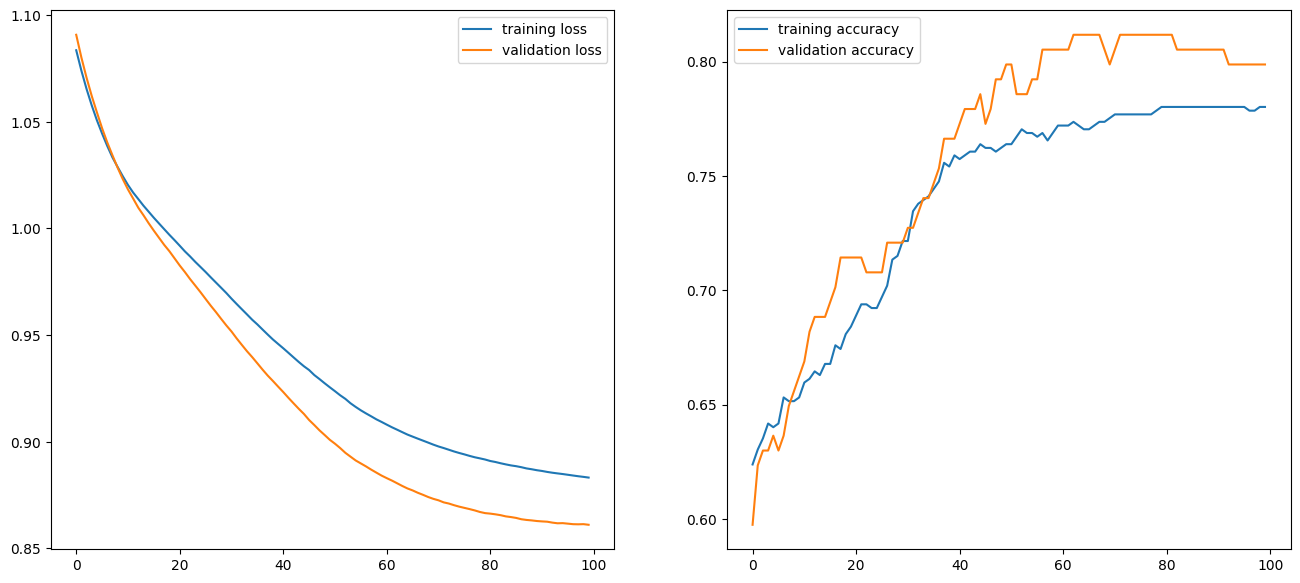

In [25]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 7))
ax[0].plot(underfit_hist.history['loss'], label = 'training loss')
ax[0].plot(underfit_hist.history['val_loss'], label = 'validation loss')
ax[1].plot(underfit_hist.history['accuracy'], label = 'training accuracy')
ax[1].plot(underfit_hist.history['val_accuracy'], label = 'validation accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

finding underfit curves : 
 
* when the traning loss curve keeps decreasing till the end of the graph, then it means that there is still room for improvement(for refrence : see above graph)
* when the training loss remains flat regardless of training.(for refrence : see below graph)
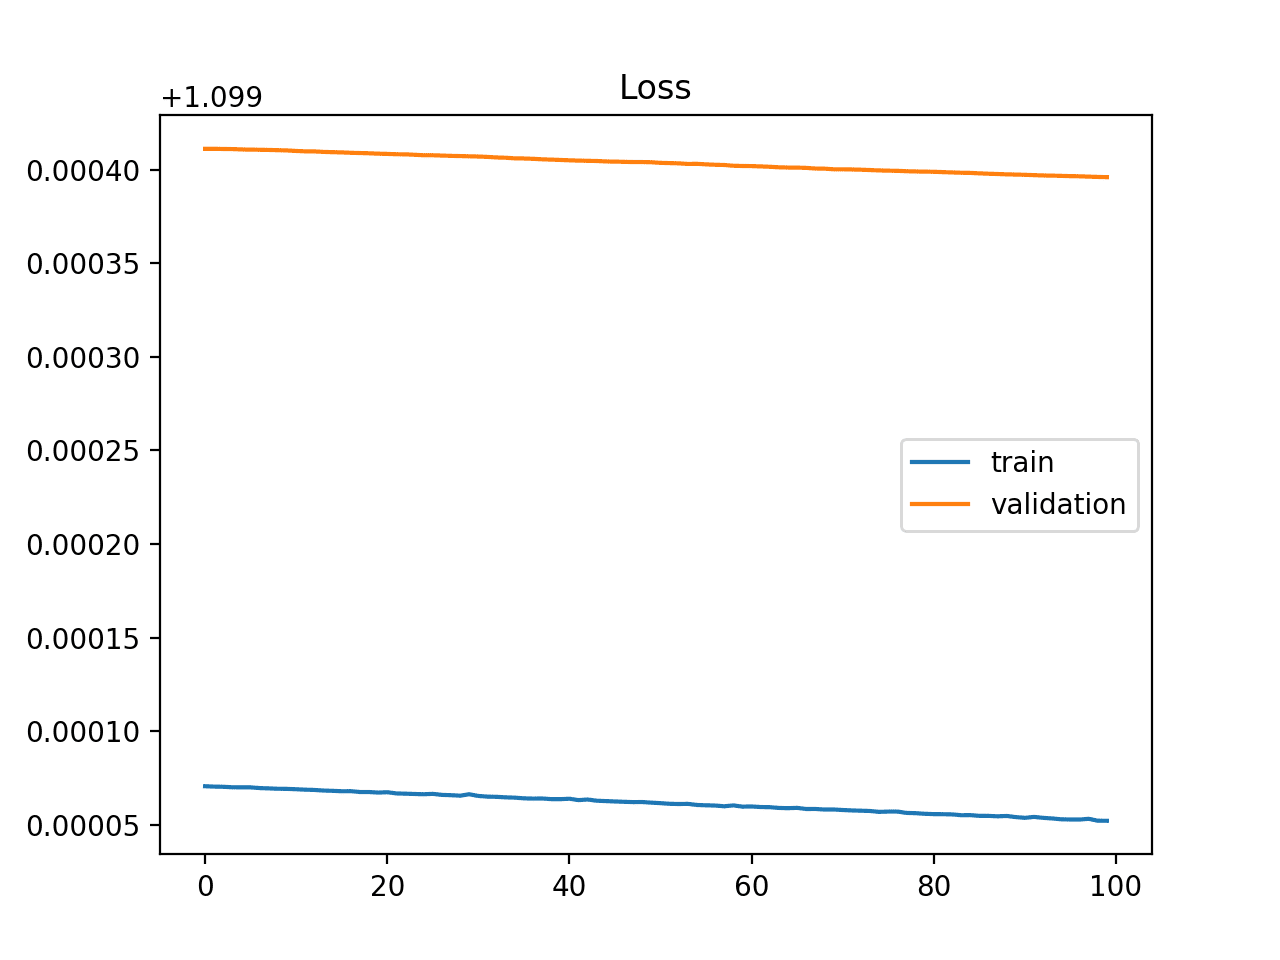


overfit learning curves

In [37]:
# overfitting model
# model = Sequential()
# model.add(Dense(8, input_shape = (8,), activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics ='accuracy')
# history = model.fit(xtrain, ytrain, epochs = 450, batch_size = 150, validation_data = (xtest, ytest))

# model.save('./learning_curves/overfit/overfit_model.keras')
# with open('./learning_curves/overfit/model_history', 'wb') as f:
#     pickle.dump(history, f)

INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp9mnw6x_6\assets


INFO:tensorflow:Assets written to: C:\Users\RAJESH\AppData\Local\Temp\tmp9mnw6x_6\assets


In [38]:
# loading the model
overfit_model = load_model('./learning_curves/overfit/overfit_model.keras')
# loading history
with open('./learning_curves/overfit/model_history', 'rb') as f:
    overfit_hist = pickle.load(f)

In [32]:
overfit_hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

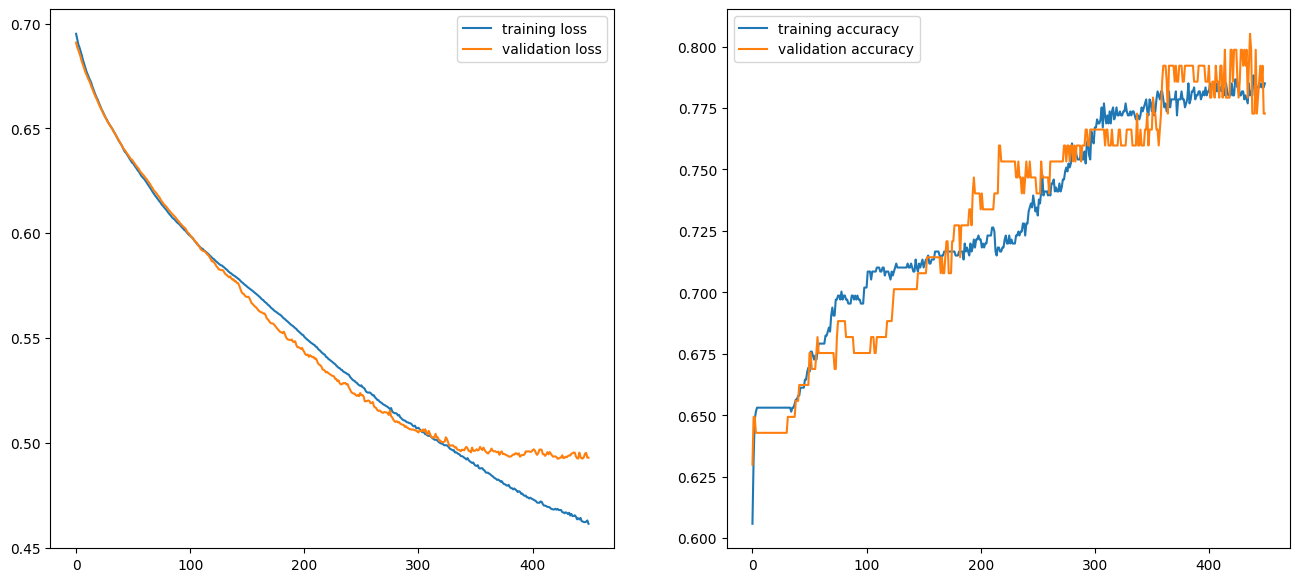

In [39]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 7))
ax[0].plot(overfit_hist.history['loss'], label = 'training loss')
ax[0].plot(overfit_hist.history['val_loss'], label = 'validation loss')
ax[1].plot(overfit_hist.history['accuracy'], label = 'training accuracy')
ax[1].plot(overfit_hist.history['val_accuracy'], label = 'validation accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

finding overfit curves : 
* training loss continues to decrease where as the validation loss starts to increase again(for refrence : see above graph)

good fit learning curves 


finding good fit curves : 
* training loss decreases to a point of stability
* validation loss decreases to a point of stability and the gap between training and validation loss is very small(for refrence : see below graph)

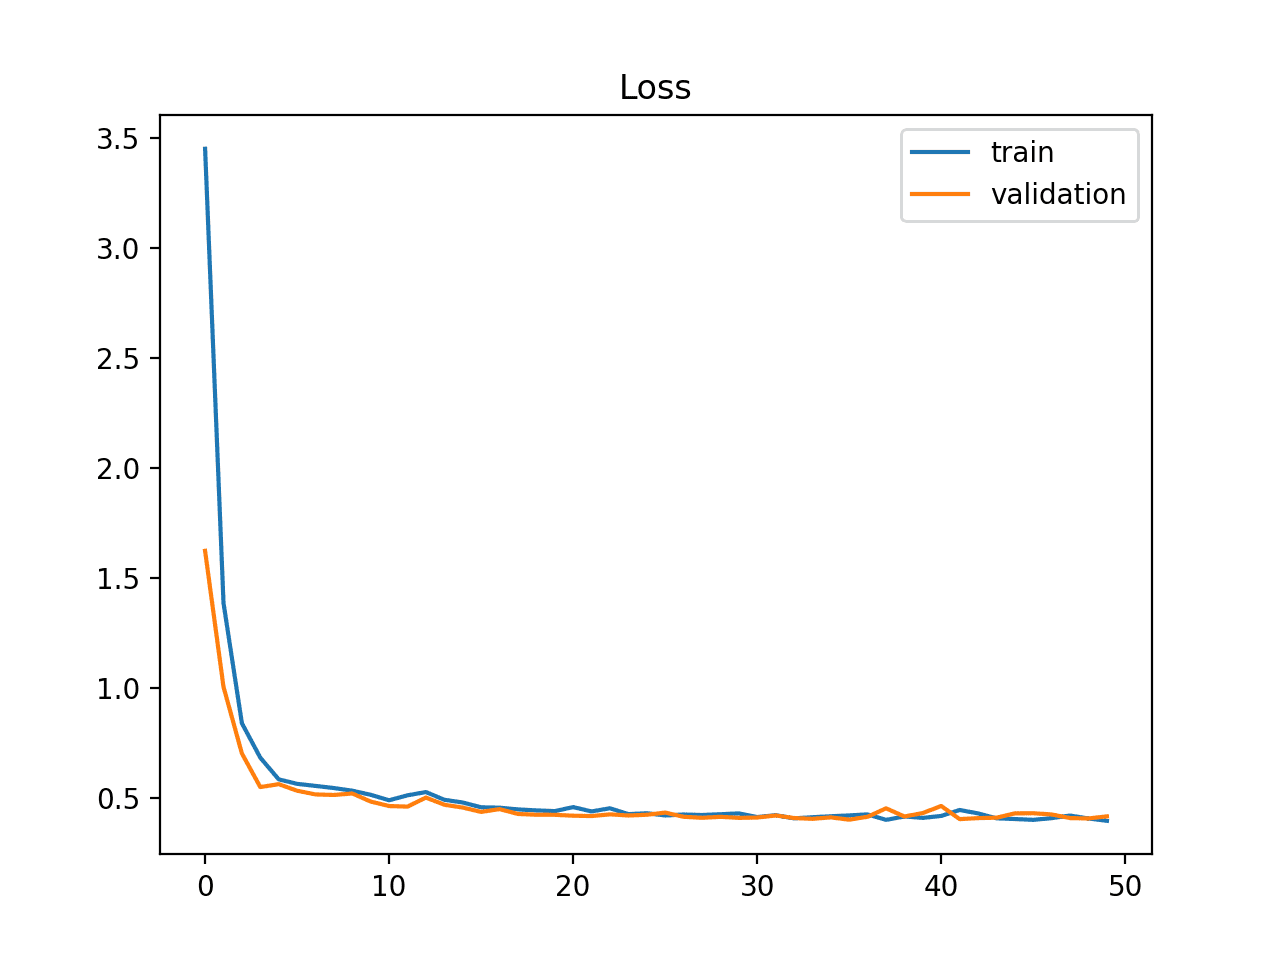

diagnosing unrepresentative datasets : 

`unrepresentative train dataset : `
    happens when the train set is not able to provide sufficient information about the problem relative to the validation data used[when train set has too few examples in compared to validation set]

* both train loss and validation loss improves but there is a large gap between both the curves(for refrence : see below graph)

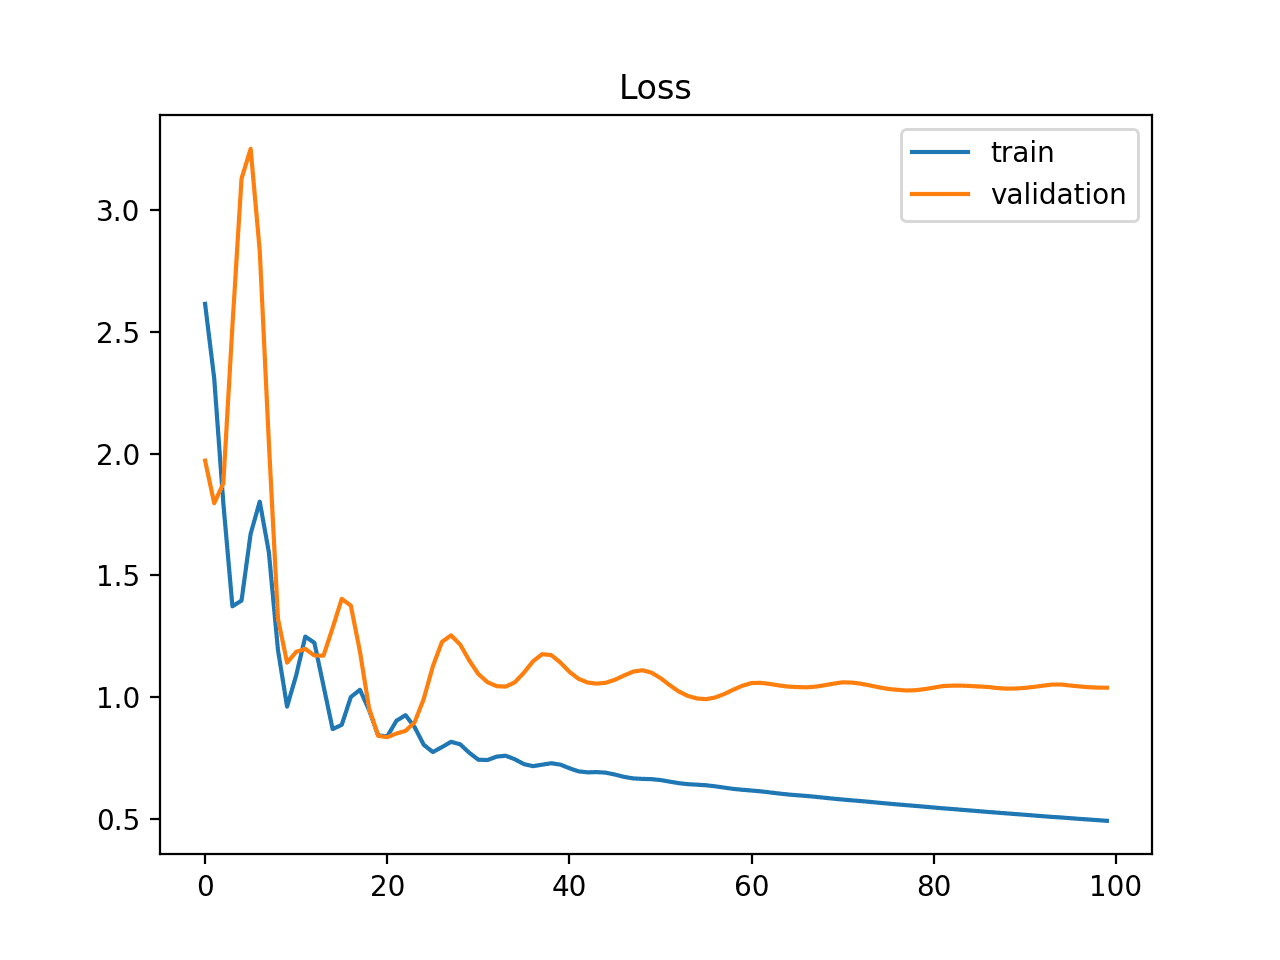


`unrepresentative train dataset : `
    happens when the validation set is not able to provide sufficient information to evaluate the model's ability to generalise

* the train loss curve looks fine, but the validation loss shows noisy movements around the train loss curve(for refrence : see below graph)

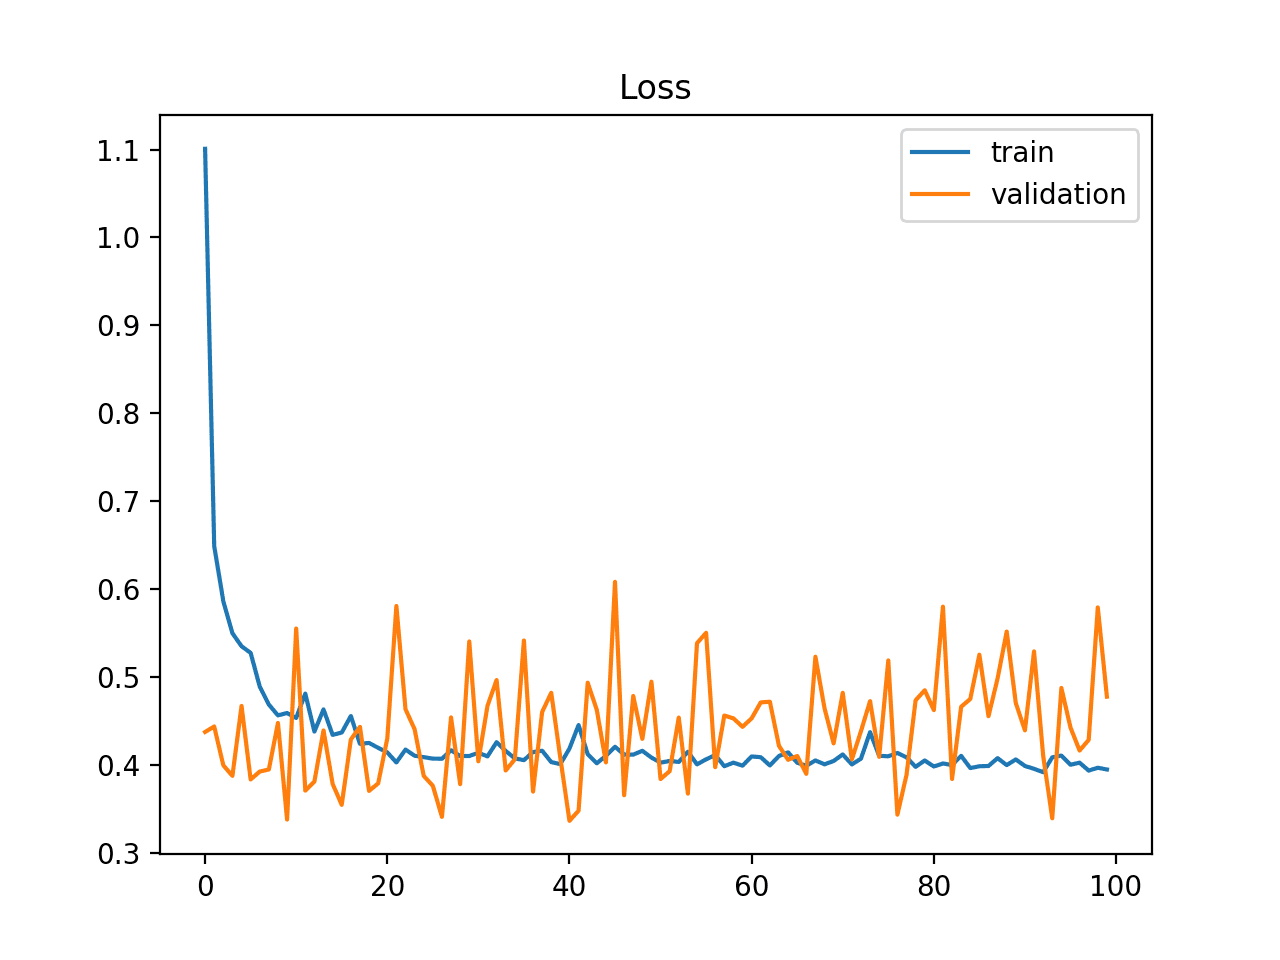

* it might also be the case where the validation loss is lower than the training loss, which means that its easier for the model to predict the validation set as compared to train set

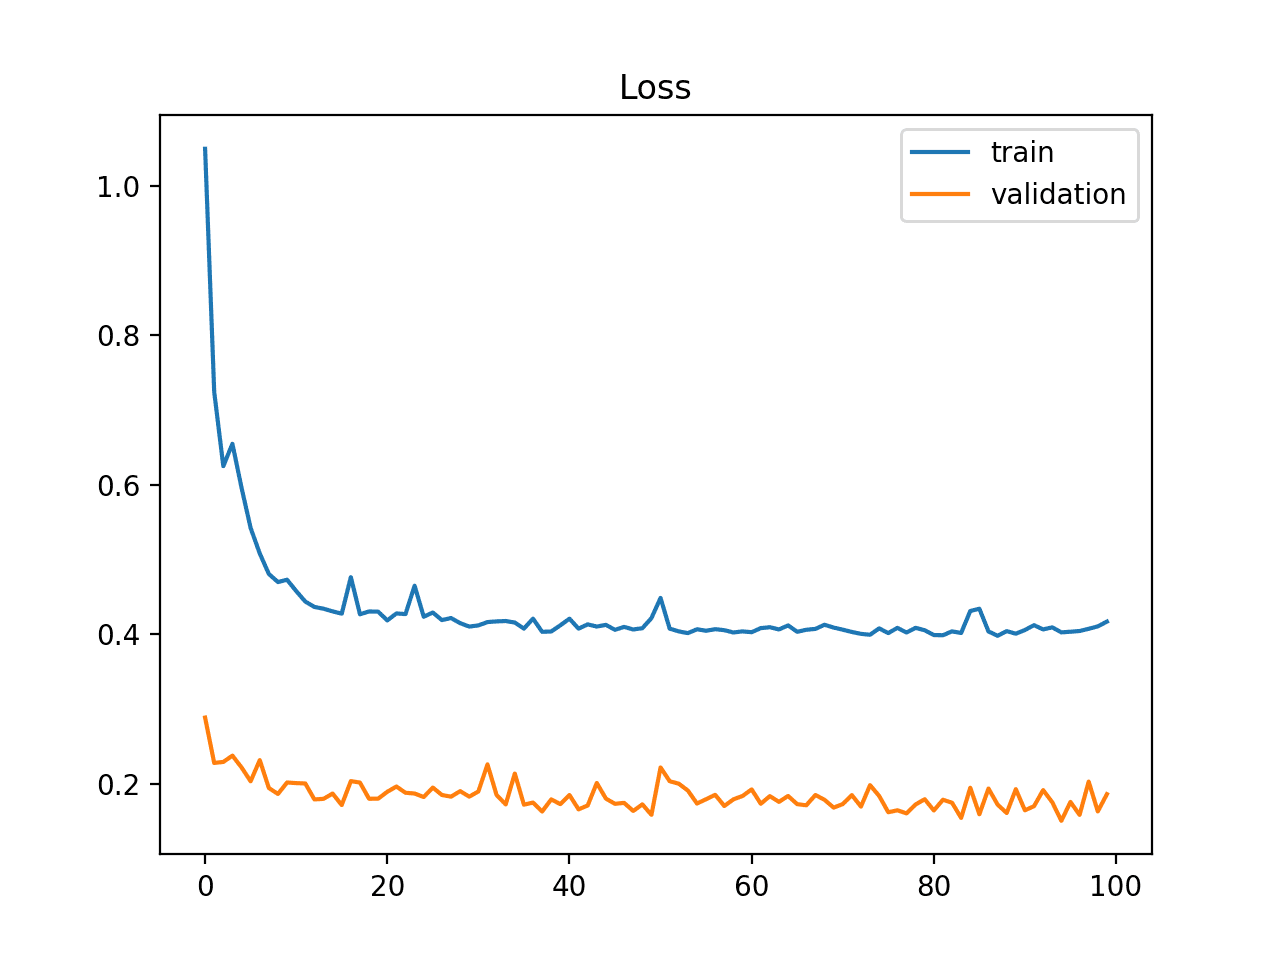

#### adverserial machine learning : way to training more robust models.

when models are tested with different data that it has not trained with, the model performes poorly. in adverserial attacks, the model is tested with data with noise to break the model. for example, for image classification, we can test the model with image that is barely noticeable with human eye, in which case the model does not able to correctly categorize the image. in speech recognition, a noise is added to the sound track. in reinforcement learning, user may try to produce fake rewards. in malicious code detection, the attacker may try to change the structure of the code to try and trick the anti-virus detection softwares, etc. 

#### how to protect against adverserial attacks?

try to include adverserial data like you can rotate the same image, or reduce the quality of the image as new examples, etc. you can purposly include noice in the speech data, etc

#### Generating Adversarial Examples

It can be generated using many methods, including gradient-based methods, genetic algorithms, and reinforcement learning. Gradient-based methods are the most commonly used. They involve computing the gradient of the loss function concerning the input and then modifying the information in the direction that increases the loss.

#### Types of Adversarial Attacks
There are several types of adversarial attacks that can be launched against machine learning models. Here are some common types:

Evasion Attacks: These attacks aim to manipulate input data in a way that causes misclassification or alters the model’s output. Examples include the Fast Gradient Sign Method (FGSM) and Iterative FGSM (I-FGSM).

Poisoning Attacks: In poisoning attacks, an attacker introduces malicious data into the training set to manipulate the model’s behavior. This can be done by injecting specially crafted samples or by modifying existing training data.

Model Inversion Attacks: Model inversion attacks attempt to reconstruct sensitive information about the training data or inputs by exploiting the model’s output. These attacks can be used to extract private information or reveal confidential data.

Membership Inference Attacks: Membership inference attacks determine whether a specific sample was part of the training data used by a model. By exploiting the model’s output probabilities, an attacker can infer the membership status of a given sample.

Model Extraction Attacks: In model extraction attacks, an adversary attempts to obtain a copy or approximation of the target model by querying it and generating a substitute model. This can be used to steal proprietary models or proprietary information embedded within the model.